Process dataset to obtain multimodal inputs

# Import dependency

In [1]:
import warnings
from rdkit import rdBase
import pandas as pd
from rdkit import RDLogger
from IPython.display import display

rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

train = False

# Cyclic peptides from CycPeptMPDB
Process all HELMS in DF to get SMILES

In [2]:
import os.path as osp
import pickle

data_path = 'data/CycPeptMPDB'

data_df = pd.read_csv(osp.join(data_path, 'raw', 'all.csv.gz'))
split_file = osp.join(data_path, 'raw', "scaffold_k_fold_idxes.pkl")
with open(split_file, 'rb') as f:
    split_idx = pickle.load(f)

smiles_list = data_df['smi'].tolist()
perm_list = data_df['score'].tolist()
display(data_df.head())

,smi,helm,score,n_mono,is_cpp,smi_len,helm_len,n_atom,smi_img,id
0,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,PEPTIDE2{[Abu].[Sar].[meL].V.[meL].A.[dA].[meL...,-6.6,11,False,227,104,85,data/CycPeptMPDB/smi_images/0.png,0
1,CC(C)C[C@@H]1NC(=O)[C@@H](CC(C)C)NC(=O)[C@@H](...,"PEPTIDE1{[dL].[dL].L.[dL].P.Y}$PEPTIDE1,PEPTID...",-6.2,6,False,120,61,51,data/CycPeptMPDB/smi_images/1.png,1
2,CC(C)C[C@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@...,"PEPTIDE1{[dL].[dL].[dL].[dL].P.Y}$PEPTIDE1,PEP...",-7.0,6,False,119,64,51,data/CycPeptMPDB/smi_images/2.png,2
3,CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc...,"PEPTIDE1{L.L.L.[dL].P.Y}$PEPTIDE1,PEPTIDE1,1:R...",-7.1,6,False,118,55,51,data/CycPeptMPDB/smi_images/3.png,3
4,CC(C)C[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C...,"PEPTIDE1{L.[dL].[dL].[dL].P.Y}$PEPTIDE1,PEPTID...",-7.2,6,False,120,61,51,data/CycPeptMPDB/smi_images/4.png,4


## Statistics of graph benchmark

In [4]:
len(data_df)

7451

In [5]:
sum(data_df['n_atom'])

494073

In [8]:
# Get degree of atoms
from rdkit import Chem
from rdkit.Chem import rdmolops
import numpy as np

def get_degree(mol):
    return np.mean([atom.GetDegree() for atom in mol.GetAtoms()])

data_df['mean_degree'] = [get_degree(Chem.MolFromSmiles(smi)) for smi in smiles_list]

np.mean(data_df['mean_degree'])

2.09331446067772

In [9]:
# Get total edges
def get_total_edges(mol):
    return rdmolops.GetAdjacencyMatrix(mol).sum()

data_df['total_edges'] = [get_total_edges(Chem.MolFromSmiles(smi)) for smi in smiles_list]

np.sum(data_df['total_edges'])

1032568

In [13]:
# Get shorted paths
def get_shortest_paths(mol):
    atoms = mol.GetAtoms()
    dist = []
    for i in range(len(atoms)):
        for j in range(i+1, len(atoms)):
            at_dist = rdmolops.GetShortestPath(mol, i, j)
            # print(at_dist)
            if at_dist is not None: dist.append(min(at_dist))
    return np.mean(dist)

data_df['avg_shortest_paths'] = [get_shortest_paths(Chem.MolFromSmiles(smi)) for smi in smiles_list]
np.mean(data_df['avg_shortest_paths'])

18.653171241895198

In [15]:
# Get average diameter of molecule
def get_diameter(mol):
    dm = Chem.GetDistanceMatrix(mol)
    return np.max(dm)

data_df['diameter'] = [get_diameter(Chem.MolFromSmiles(smi)) for smi in smiles_list]
np.mean(data_df['diameter'])

20.05113407596296

<Axes: >

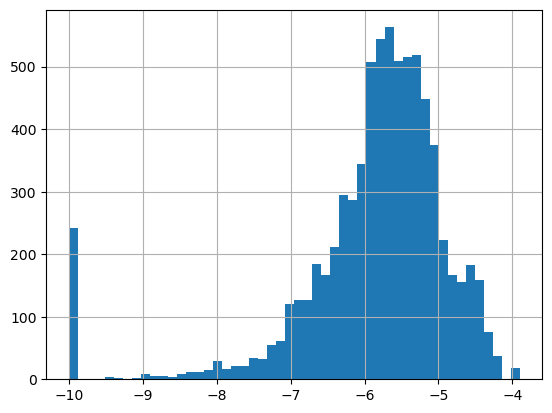

In [8]:
display(data_df['score'].hist(bins=50))

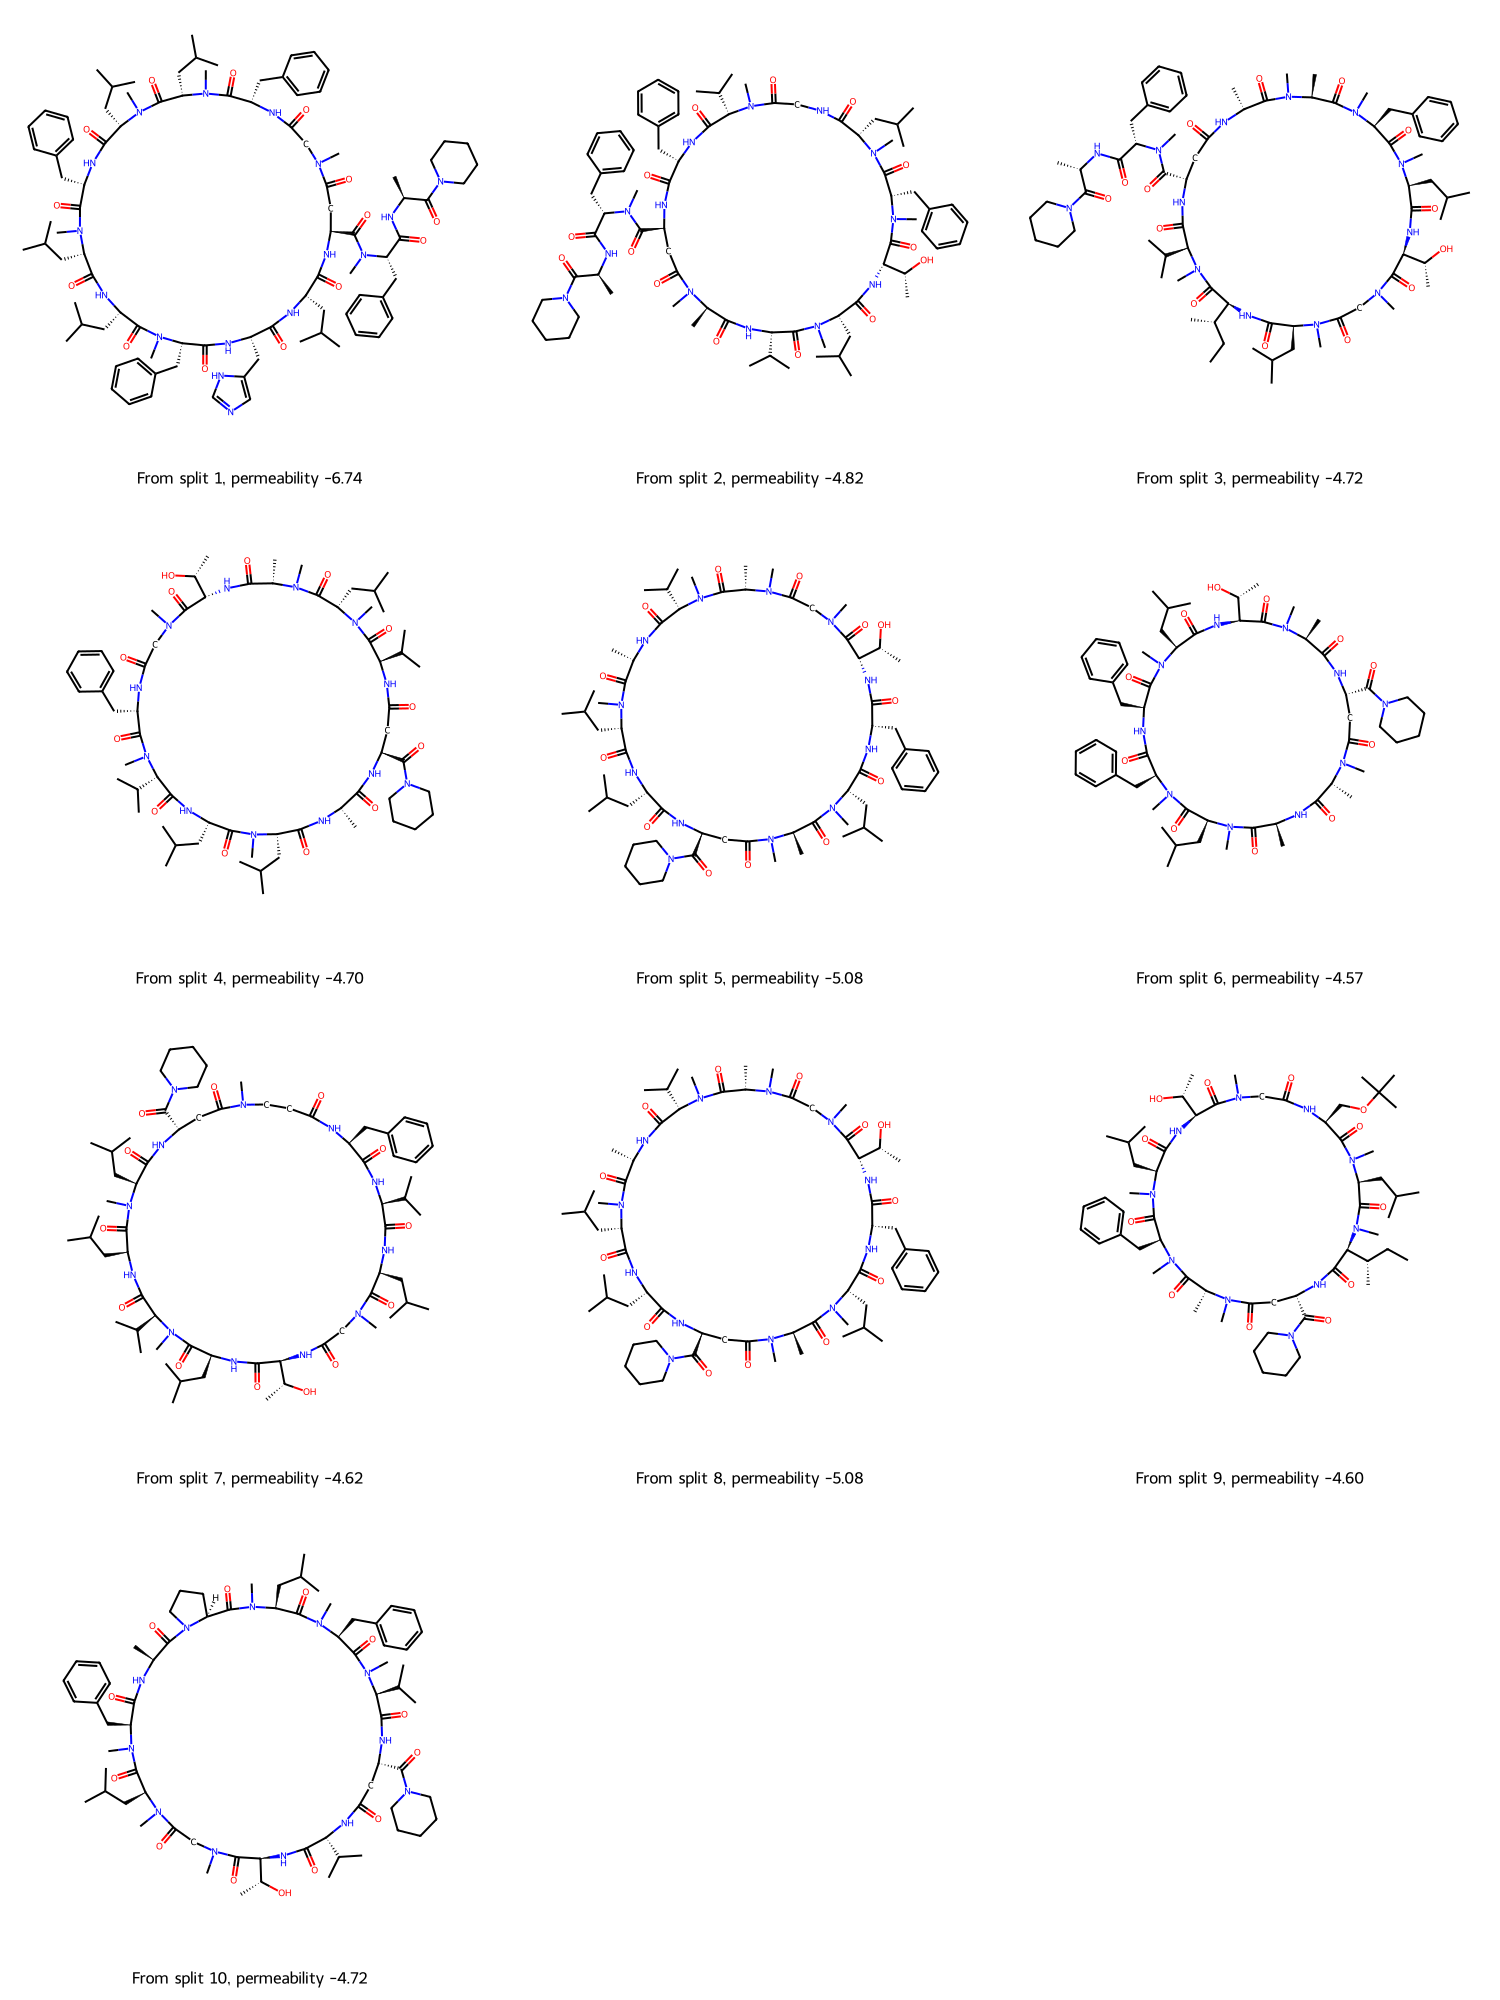

In [65]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

# show random examples of molecules in each split
mols, perm = [], []
for split in split_idx:
    rand_idx = np.random.randint(0, len(split))
    mols.append(Chem.MolFromSmiles(smiles_list[rand_idx]))
    perm.append(perm_list[rand_idx])

legends=[f"From split {i+1}, permeability {p:.2f}" for i, p in enumerate(perm)]
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(500, 500), legends=legends, returnPNG=False)
display(img)
# img.save('data/CycPeptMPDB/figures/split_examples.pdf')

In [41]:
from utils.splitters import generate_scaffold

scaffolds = [generate_scaffold(smi, include_chirality=True) for smi in smiles_list]
scaffold_counts_in_split = [np.unique([scaffolds[i] for i in split], return_counts=True) for split in split_idx]

In [43]:
len(scaffold_counts_in_split)

10

In [70]:
scaffold_counts_in_split[5]

(array(['O=C1CCCCNC(=O)[C@H](Cc2ccccc2)NC(=O)CNC(=O)CN1',
        'O=C1CCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CN1',
        'O=C1CCCNC(=O)C[C@@H](C(=O)N2CCCCC2)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2ccccc2)NC(=O)CNC(=O)CN1',
        'O=C1CCNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)CN1',
        'O=C1CN(Cc2ccccc2)C(=O)CNC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC(=O)CNC(=O)[C@@H]2CCCN2C(=O)CN1',
        'O=C1CN(Cc2ccccc2)C(=O)CNC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC(=O)CNC(=O)[C@@H]2CCCN2C(=O)C[C@H](Cc2ccccc2)N1',
        'O=C1CN(Cc2ccccc2)C(=O)CNC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC(=O)CNC(=O)[C@H]2CCCN2C(=O)CN1',
        'O=C1CN(Cc2ccccc2)C(=O)CNC(=O)[C@H](Cc2ccccc2)NC(=O)CNC(=O)[C@@H]2CCCN2C(=O)CN1',
        'O=C1CN(Cc2ccccc2)C(=O)CNC(=O)[C@H](Cc2ccccc2)NC(=O)CNC(=O)[C@H]2CCCN2C(=O)CN1',
        'O=C1CN(Cc2ccccc2)C(=O)CNC(=O)[C@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC(=O)CNC(=O)[C@@H]2CCCN2C(=O)CN1',
        'O=C1CN(Cc2ccccc2)C(=O)CNC(=O)[C